In [1]:
%matplotlib inline

import tensorflow as tf
import menpo.io as mio
import utils

from menpofit.visualize import plot_cumulative_error_distribution

In [2]:
# Download pretrained model.
!wget https://www.doc.ic.ac.uk/~gt108/theano_mdm.pb --no-check-certificate

# Download 300W dataset from http://ibug.doc.ic.ac.uk/resources/300-W/.
images = mio.import_images('PATH_TO_300w')

In [3]:
MDM_MODEL_PATH = 'theano_mdm.pb'
bounding_boxes_path = Path('bbs/300w/')

In [4]:
# the image to fit (rgb image of HWC) where H: height, W: weight and C
# the number of channels (=3).
image = tf.placeholder(tf.float32, shape=(None, None, 3), name='images')

# we only use the upper-left (x0, y0) and lower-down (x1, y1) points
# of the bounding box as a vector (x0, y0, x1, y1).
initial_bb = tf.placeholder(tf.float32, shape=(4), name='inits')

## Load the model

In [5]:
with open(MDM_MODEL_PATH, 'rb') as f:
    graph_def = tf.GraphDef.FromString(f.read())
    pred,  = tf.import_graph_def(graph_def, input_map={"image": image, "bounding_box": initial_bb}, return_elements=['prediction:0'])

In [6]:
# Start TensorFlow session.
sess = tf.InteractiveSession()

## Fitting images

In [7]:
def outer_eye_corner_68(prediction, ground_truth):
    """Computes the outer-eye corner normalised rmse error.
    
    Args:
      prediction: A menpo `PointCloud' with the predicted landmarks.
      ground_truth: A menpo `PointCloud' with the ground truth landmarks.
    Returns:
      A scalar with the normalized error.
    """
    
    num_landmarks = 68
    assert prediction.points.shape[0] == num_landmarks
    assert ground_truth.points.shape[0] == num_landmarks

    interocular_dist = np.linalg.norm(ground_truth.points[36] - ground_truth.points[45])    
    rmse_error = np.sum(np.linalg.norm(prediction.points - ground_truth.points, axis=-1))

    return rmse_error / (num_landmarks * interocular_dist)

In [8]:
def fit_image(im):
    """Estimates the landmarks usign the provided image and bounding box.
    
    Args:
        A menpo `Image' with the bounding_box attached.
    Returns:
        A menpo `PointCloud' with the predicted landmarks.
    """
    # menpo stores images CHW instead of HWC that TensorFlow uses.
    pixels = im.pixels.transpose(1, 2, 0)

    # the model expects rgb images.
    if im.n_channels == 1:
        pixels = np.dstack([pixels]*3)

    bounding_box = im.landmarks['bounding_box'].lms

    prediction, = sess.run(pred, feed_dict={
        image: pixels,
        # grab the upper-left and lower-down points of the bounding box.
        initial_bb: bounding_box.points[[0, 2]].ravel()}
    )
    
    return menpo.shape.PointCloud(prediction)

In [9]:
errors = []

images_iter = menpo.visualize.print_progress(images, prefix='Loading and fitting images')

for im in images_iter:
    bb_name = im.path.stem + '.pts'
    bounding_box = mio.import_landmark_file(bounding_boxes_path / bb_name)[None]
    im.landmarks['bounding_box'] = bounding_box

    mirrored_fit = utils.mirror_landmarks_68(
        fit_image(utils.mirror_image_bb(im)), im.shape)

    prediction = menpo.shape.mean_pointcloud((fit_image(im), mirrored_fit))
    
    error = outer_eye_corner_68(prediction, im.landmarks['PTS'].lms)
    errors.append(error)

Loading and fitting images: [==========] 100% (600/600) - done.                 


## Visualising results

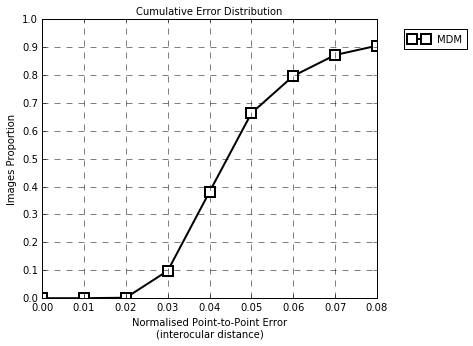

In [10]:
plt.yticks(np.linspace(0, 1, 11))

plot_cumulative_error_distribution(
    [errors],
    error_range=(0., 0.09, .01), 
    legend_entries=['MDM'], 
    line_colour=[ 'k'], 
    marker_edge_colour=['k'],
    marker_style=['s'],
    figure_size=(6, 5),
    marker_size=10,
    x_label='Normalised Point-to-Point Error\n(interocular distance)',
);